## Pymc Exercise

In [97]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from pymc import *
from matplotlib import pyplot as plt
import pandas as pd
import scipy
from scipy import stats
from pylab import hist, show

#### Exercise 1:  Estimating mean and standard deviation of normal distributed data

Given are normal distributed data:
$$
 X \sim \mathcal N(\mu, \sigma^2)
$$


Probability Density Function:
$$
f(X \mid \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left\{ -\frac{\tau}{2} (X-\mu)^2 \right\}
$$

with  
- $\mu$: mean
- $\sigma$: standard deviation
- $\sigma^2$ : variance
- precision $\tau := 1/\sigma^2$ 

(array([  1.,   2.,   0.,  10.,  16.,  23.,  23.,  12.,   8.,   5.]),
 array([  3.03541225,   4.12695821,   5.21850416,   6.31005012,
          7.40159608,   8.49314204,   9.584688  ,  10.67623395,
         11.76777991,  12.85932587,  13.95087183]),
 <a list of 10 Patch objects>)

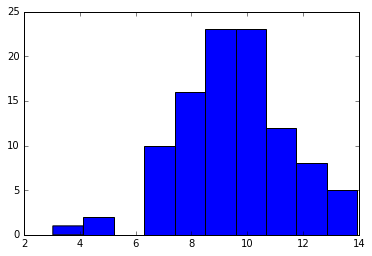

In [98]:
# load the data from file
y = np.load("normal_data.npy")

plt.hist(y)

#### Exercise
- Use pymc to determine the mean and standard deviation of the data.
- Plot the distribution of the mean and the standard deviation
- What is the 95% credible intervall of the mean and the standard deviation?

 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 sec
mean:  9.51065710701
standard deviation:  1.96410832841
Confidence Interval: 9.12198949827 - 9.87741951933
confidence interval: 5.66107552159 - 13.3602386924


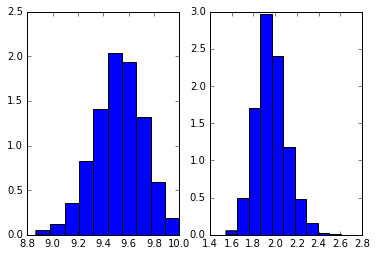

In [100]:
# priors / our parameters
mu = pymc.Uniform('mu', lower=0, upper=10)
tau = pymc.Uniform('tau', lower=0, upper=1)

# likelihood using normal distribution
y_observed = pymc.Normal('y_observed', mu=mu, tau=tau, value=y, observed=True)

# creating model
model = pymc.Model([mu, tau, y])
mc = pymc.MCMC(model)
# sampling --> 20k samples, burn first 10k 
mc.sample(iter=20000, burn=10000)

# mean and standard deviation
samples = np.array(mu.trace())
mean = np.mean(means)
print ""
print "mean: ", mean
std_devs = np.sqrt(1.0 / tau.trace())
std_dev = np.mean(std_devs)
print "standard deviation: ", std_dev

# plotting
plt.subplot(121)
# mean plot
plt.hist(mu.trace(), normed=True)
plt.subplot(122)
# standard deviation plot
plt.hist(np.sqrt(1.0/tau.trace()), normed=True)
plt.show

# confidence interval
ci=scipy.stats.norm.interval(0.95, loc=mean, scale=std_dev)
print "Confidence Interval: " + str(np.percentile(samples, 2.5)) + " - " + str(np.percentile(samples, 97.5))
print "confidence interval: " + str(ci[0]) + " - " + str(ci[1])




### Estimating parameters of a linear regression model

Simple linear model:

$$
y \sim ax + b
$$ 


Linear model with noise:
$$
y = ax + b + \epsilon
$$

Considered as sampling from a probability distribution

$$
y \sim \mathcal N (ax + b, \sigma^2)
$$ 




In [91]:
data = pd.read_pickle("linear_data.pkl")

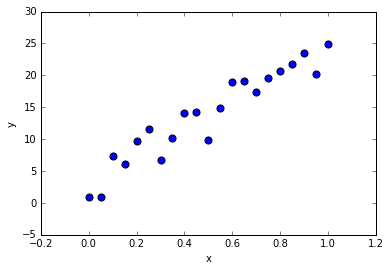

In [92]:
data.plot(x='x', y='y', kind='scatter', s=50)

Exercise:

- Use pymc to estimate the paramters $a, b$ and $\sigma$. Assume appropirate priors.
- Plot the distribution of the parameters.
- Plot the data with multiple regression lines. 



 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec
sigma:  6.93008507638
a mean:  20.2772210269
b mean:  3.18822188912


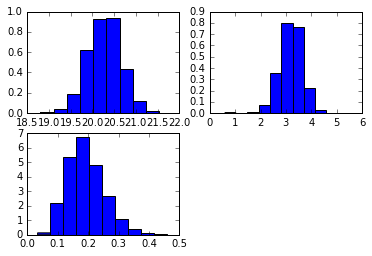

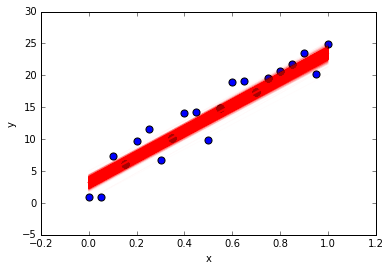

In [95]:
sigma =  np.std(data.y)

# number of y values
n = data.y.size
# Return evenly spaced numbers over a specified interval
x = np.linspace(0, 1, n)

# priors
#a = pymc.Normal('a', mu=0, tau=1.0 / 1000)
#b = pymc.Normal('b', mu=0, tau=1.0 / 1000)
a = pymc.Normal('a', mu=20, tau=6)
b = pymc.Normal('b', mu=2, tau=2)
tau = pymc.Gamma('tau', alpha=0.1, beta=0.1)

# likelihood, simple linear model
@pymc.deterministic
def mu(a=a, b=b, x=x):
    return a*x + b

# normal distribution
y = pymc.Normal('y', mu=mu, tau=tau, value=data.y, observed=True)

# creating model
model = pymc.Model([a, b, tau, x, y])
mc = pymc.MCMC(model)
# sampling
mc.sample(iter=20000, burn=10000)
# samples and mean calculating
samples_a = np.array(a.trace())
mean_a = np.mean(samples_a)
samples_b = np.array(b.trace())
mean_b = np.mean(samples_b)


print ""
print "sigma: ", sigma
print "a mean: ", mean_a
print "b mean: ", mean_b

# plotting
plt.subplot(221)
plt.hist(a.trace(), normed=True)
plt.subplot(222)
plt.hist(b.trace(), normed=True)
plt.subplot(223)
plt.hist(tau.trace(), normed=True)
plt.show

data.plot(x='x', y='y', kind='scatter', s=50)
xp = np.array([x.min(), x.max()])
plt.plot(a.trace()*xp[:, None] + b.trace(), c='red', alpha=0.01)
plt.plot(xp, mean_a*xp + mean_b, linewidth=2, c='red');
